#

#### The client is launching a new ride sharing program in New York similar to Uber or Lyft. At the end of each trip they want their app to suggest a tip amount to the rider. The company has not acquired any of their own data yet, so they have tasked you with producing a model based off of the taxi data. This model should predict the likely tip amount for a trip based on the other trip attributes. You can assume that the ride sharing company can provide data that has the same attributes as the taxi data for each trip.

#### This data can be found here: (NYC Taxi & Limousine Commission - Trip Record Data) and is described by the data dictionary (https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)



In [1]:
# Import libraries for data analytics
import os 
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import warnings
import math
from scipy import stats
warnings.filterwarnings('ignore')

In [4]:
data03 = pd.read_csv('yellow_tripdata_2017-03.csv')
data06 = pd.read_csv('yellow_tripdata_2017-06.csv')
data09 = pd.read_csv('yellow_tripdata_2017-09.csv')
data11 = pd.read_csv('yellow_tripdata_2017-11.csv')

In [5]:
data03.shape,data06.shape,data09.shape,data11.shape

((10294628, 17), (9656993, 17), (8945459, 17), (9284803, 17))

In [6]:
# merge 
df = pd.concat([data03,data06,data09,data11])

print ('This dataset contains {} obs. with {} variables'.format(*df.shape))

This dataset contains 38181883 obs. with 17 variables


### Data Preparation
##### 1. We keep Credit Card (1) only, because Cash Tips are not recorded in Tip_amount.
##### 2. We create new variable to record the driving time, and remove some mistaken values.
##### 3. Double check the dataset by visualizing distribution of Total Amount, Trip_distance and Driving_time.


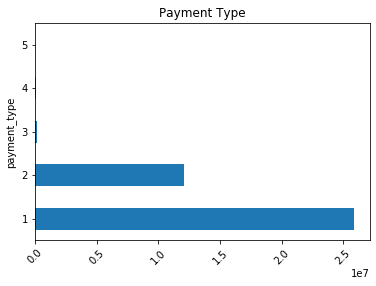

In [7]:
# First check payment types 
df.groupby('payment_type')['VendorID'].count().plot(kind='barh',title='Payment Type')
#plt.ylim([0,6])
plt.xticks(rotation=45)
plt.show()

In [8]:
# According to the challenge requests, we keep the payment type 1 =credit card only  
df = df[df['payment_type']==1]

#### Passenger counts are driver_entered value from 1 to 6. In most cases, taxi stops for only 1 or 2 passengers.

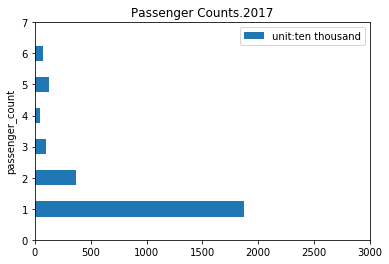

In [9]:
## passenger counts 
((df.groupby('passenger_count')['VendorID'].count())/int(10000)).plot(kind='barh',title='Passenger Counts.2017')
plt.ylim([0,7])
plt.xlim([0,3000])
plt.legend(['unit:ten thousand'],loc='best')
plt.show()

#### Transform to Date, Weekday and Hours, then create new variables;

In [10]:
# format and make date/hour features 
df['tpep_pickup_datetime']=pd.to_datetime(df['tpep_pickup_datetime'])
df['date'] = df['tpep_pickup_datetime'].dt.date
df['hour'] = df['tpep_pickup_datetime'].dt.hour
df['weekday_name'] = df['tpep_pickup_datetime'].dt.weekday_name

df['tpep_dropoff_datetime']=pd.to_datetime(df['tpep_dropoff_datetime'])
df['date_dp'] = df['tpep_dropoff_datetime'].dt.date
df['hour_dp'] = df['tpep_dropoff_datetime'].dt.hour
df['weekday_name_dp'] = df['tpep_dropoff_datetime'].dt.weekday_name

#Then create new variable of driving time
df['duration_minutes'] = (df['tpep_dropoff_datetime']-df['tpep_pickup_datetime']).astype('timedelta64[m]')

#### After checking the descriptive of driving time, we simply assume those negative time durations are recored wrongly, we remove them (instead of correting them in this report). 
#### Besides, we find some obvious mistakes, for instance, one passenger 'spent' over 10 days in the taxi and paid 8.75 only; one passenger paid 900 dollars to the drivers but we miss all other info.. 
#### Becasue of time limitation,we will use the conventional methods to remove outliers directly in this part.

In [31]:
# remove negative time duration
df = df[df['duration_minutes']>0]
#df[df['duration_minutes']==df['duration_minutes'].max()]
df2 = df.copy()

# find the outliers by 5% and 95% cf.
outlier_lower = df2['duration_minutes'].quantile(0.05)
outlier_upper = df2['duration_minutes'].quantile(0.95)
removed_duration_minutes = df2['duration_minutes'].between(outlier_lower,outlier_upper)
index_removed = df2[~removed_duration_minutes].index

# Outlier removed!
df2.drop(index_removed,inplace=True)
print(removed_duration_minutes.value_counts())

True     23608670
False     2123393
Name: duration_minutes, dtype: int64


In [12]:
"""outlier_lower_ttamount = df2['total_amount'].quantile(0.05)
outlier_upper_ttamount = df2['total_amount'].quantile(0.95)
removed_duration_ttamount = df2['total_amount'].between(outlier_lower_ttamount,outlier_upper_ttamount)
index_removed_ttamount = df2[~removed_duration_ttamount].index
df2.drop(index_removed_ttamount,inplace=True)
print(removed_duration_ttamount.value_counts())"""

"outlier_lower_ttamount = df2['total_amount'].quantile(0.05)\noutlier_upper_ttamount = df2['total_amount'].quantile(0.95)\nremoved_duration_ttamount = df2['total_amount'].between(outlier_lower_ttamount,outlier_upper_ttamount)\nindex_removed_ttamount = df2[~removed_duration_ttamount].index\ndf2.drop(index_removed_ttamount,inplace=True)\nprint(removed_duration_ttamount.value_counts())"

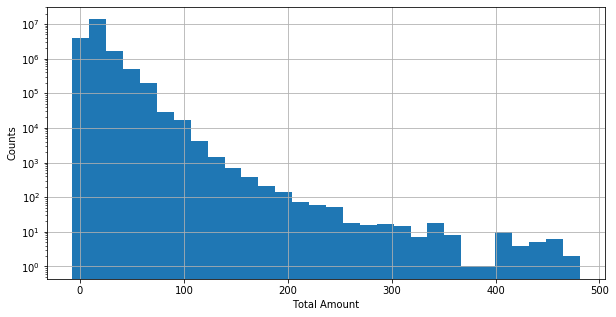

In [13]:
ax_ttamount = df2['total_amount'].hist(bins=30, figsize=(10,5))
ax_ttamount.set_yscale('log')
ax_ttamount.set_xlabel("Total Amount")
ax_ttamount.set_ylabel("Counts")
plt.show()

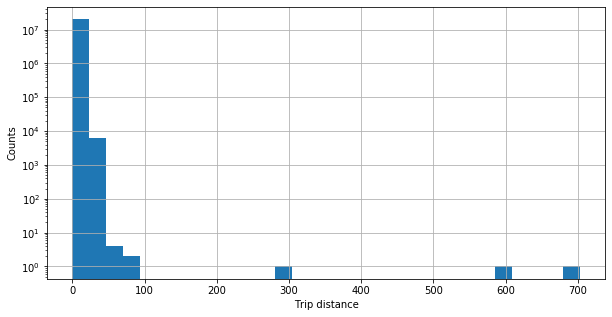

In [14]:
ax_dis = df2['trip_distance'].hist(bins=30, figsize=(10,5))
ax_dis.set_yscale('log')
ax_dis.set_xlabel("Trip distance")
ax_dis.set_ylabel("Counts")
plt.show()

In [15]:
df2['trip_distance'].describe()

count    2.003622e+07
mean     2.662729e+00
std      2.868912e+00
min      0.000000e+00
25%      1.080000e+00
50%      1.700000e+00
75%      2.990000e+00
max      7.025000e+02
Name: trip_distance, dtype: float64

#### Based on the distribution of trip_distance, we decide to define short-distance that less than 10, long-distiance over 10. Then we analyse the peak and off peak hour in the next section.

In [32]:
# we define short_trip =0 and long_trip =1
df2['trip_type']=0
df2['trip_type']=np.where((df2['trip_distance']>=10),1,df2['trip_type'])
# Approximate 20000000 short_trip case and 700000 long_trip case
df2.groupby('trip_type')['VendorID'].count()

trip_type
0    19350260
1      685960
Name: VendorID, dtype: int64

#### From the line chart below, we can say that the demand of taxis incresed after 3pm. The peak  hours are around 19pm, the off-peak hours is 5am in the morning. Besides that, more passengers need taxi services in Wednesday, Thursday and Friday. 

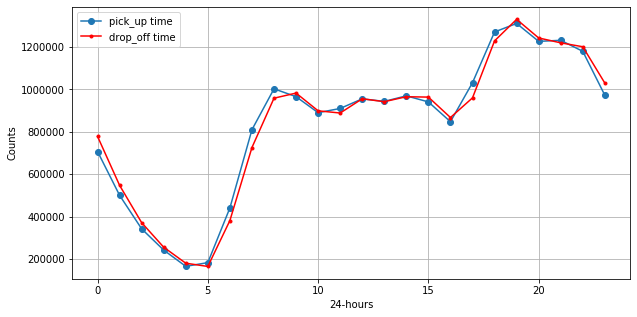

In [17]:
x = range(0,24)
plt.figure(figsize=(10,5))
plt.plot(x,df2.groupby('hour')['VendorID'].count(),'o-')
plt.plot(x,df2.groupby('hour_dp')['VendorID'].count(),'.-',color='r')
plt.xlabel('24-hours')
plt.ylabel('Counts')
plt.legend(('pick_up time','drop_off time'),loc='best')

plt.grid(True)
plt.show()

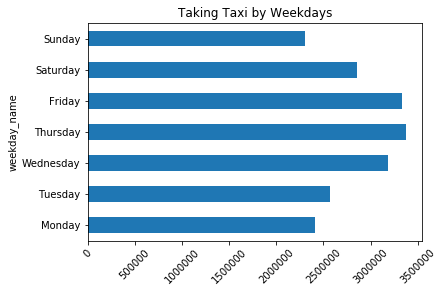

In [18]:
df2.groupby('weekday_name')['VendorID'].agg('count')\
 .T[['Monday','Tuesday','Wednesday','Thursday','Friday',
    'Saturday','Sunday']].plot(kind='barh',title='Taking Taxi by Weekdays')
plt.xticks(rotation=45)
plt.show()

#### We compared the weekdays taxi demads by trip distances.
#### For short distance trips, more taxis are needed on Friday (16.96%), Monday(16.68%) and Sunday(15.95%); While long distances trips are needed on Thursday(17.13%) and Monday(15.02%) most.


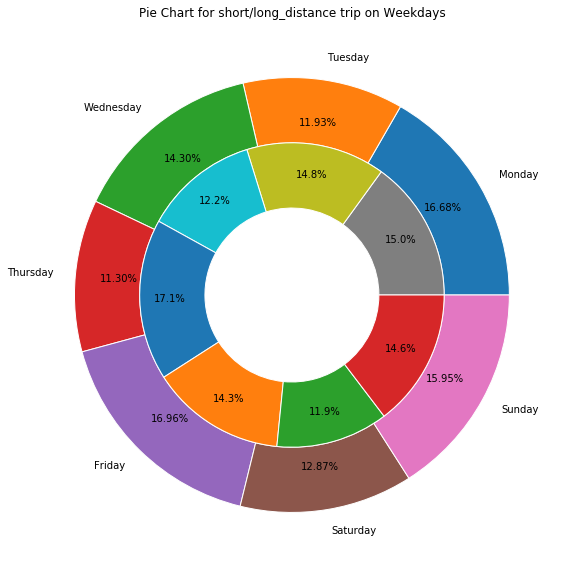

In [19]:
labels = ['Monday','Tuesday','Wednesday','Thursday','Friday',
    'Saturday','Sunday']
short_trip = df2[df2['trip_type']==0].groupby('weekday_name')['VendorID'].agg('count')
fig = plt.figure(figsize=(10,10))
size = 0.3

plt.pie(short_trip,labels=labels,autopct='%1.2f%%',pctdistance=0.8,\
                          radius = 1,wedgeprops=dict(width=size, edgecolor='w'))

long_trip = df2[df2['trip_type']==1].groupby('weekday_name')['VendorID'].agg('count')
plt.pie(long_trip,autopct='%1.1f%%',pctdistance=0.8,\
        radius = 1-size,wedgeprops=dict(width=size, edgecolor='w'))
plt.title('Pie Chart for short/long_distance trip on Weekdays')
plt.show()

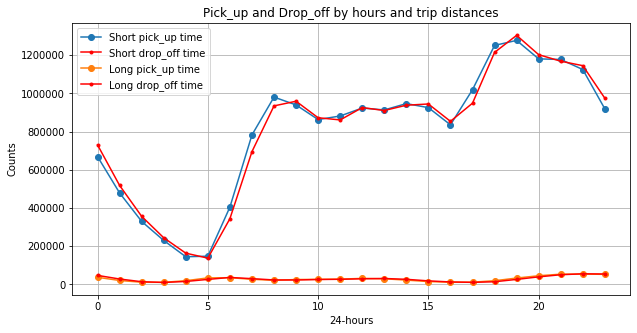

In [20]:
x = range(0,24)
plt.figure(figsize=(10,5))
plt.plot(x,df2[df2['trip_type']==0].groupby('hour')['VendorID'].count(),'o-')
plt.plot(x,df2[df2['trip_type']==0].groupby('hour_dp')['VendorID'].count(),'.-',color='r')

plt.plot(x,df2[df2['trip_type']==1].groupby('hour')['VendorID'].count(),'o-')
plt.plot(x,df2[df2['trip_type']==1].groupby('hour_dp')['VendorID'].count(),'.-',color='r')

plt.xlabel('24-hours')
plt.ylabel('Counts')
plt.legend(('Short pick_up time','Short drop_off time','Long pick_up time','Long drop_off time'),loc='best')
plt.title('Pick_up and Drop_off by hours and trip distances')
plt.grid(True)
plt.show()

#### In next section, we build models to predict tip_amount.
#### Start with Heatmap for feature selection. Remove those variables not related to target varaible. 
#### Applied two algorithoms RandomForest and Linear Regression to predict.

In [33]:
df2_cor_col = df2[['passenger_count','trip_distance','fare_amount','extra',\
                    'mta_tax','tip_amount','tolls_amount','improvement_surcharge',\
                    'total_amount','duration_minutes','date','hour','hour_dp']]
df2_cor = df2_cor_col.corr()

[Text(0.5, 0, 'passenger_count'),
 Text(1.5, 0, 'trip_distance'),
 Text(2.5, 0, 'fare_amount'),
 Text(3.5, 0, 'extra'),
 Text(4.5, 0, 'mta_tax'),
 Text(5.5, 0, 'tip_amount'),
 Text(6.5, 0, 'tolls_amount'),
 Text(7.5, 0, 'improvement_surcharge'),
 Text(8.5, 0, 'total_amount'),
 Text(9.5, 0, 'duration_minutes'),
 Text(10.5, 0, 'hour'),
 Text(11.5, 0, 'hour_dp')]

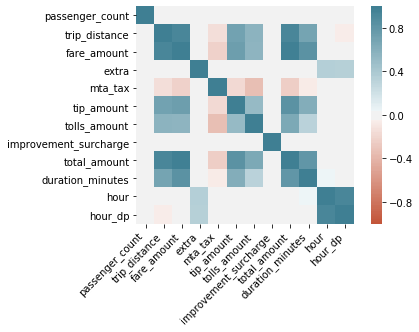

In [23]:
# plot 
ax_heatmap = sns.heatmap(df2_cor,
                vmin=-1,vmax=1,center=0,
                cmap=sns.diverging_palette(20,220,n=200),
                square=True)

ax_heatmap.set_xticklabels(ax_heatmap.get_xticklabels(),
                  rotation=45,
                  horizontalalignment='right')

In [34]:
# adjusted dataset
df3 = df2.drop(['passenger_count','extra','improvement_surcharge','mta_tax','VendorID','payment_type','tpep_dropoff_datetime','tpep_pickup_datetime','store_and_fwd_flag','RatecodeID','hour','hour_dp','date','weekday_name','date_dp','weekday_name_dp'],axis=1)

#### Split data set 

In [35]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [36]:
y_set = df3['tip_amount'].astype('int')
X_set = df3.drop('tip_amount',axis=1)

In [37]:
X_train,X_test,y_train,y_test = train_test_split(X_set,y_set,random_state=1)

In [38]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((15027165, 8), (5009055, 8), (15027165,), (5009055,))

#### Random Forest  Regression

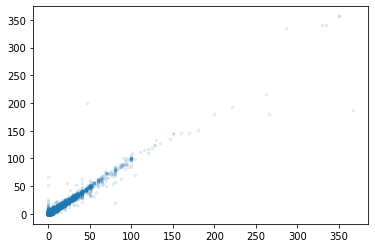

In [42]:
rf = RandomForestRegressor(n_estimators= 10, min_samples_leaf=5,random_state=1)

# fitting DecisionTree to the training set
rf.fit(X_train,y_train)

# predicting the testset results 
y_pred_rf = rf.predict(X_test)
plt.scatter(y_test,y_pred_rf,alpha=0.1,s=6)


In [43]:
print('So,the accuracy score is :{}'.format(round(metrics.r2_score(y_test,y_pred_rf),3)))

So,the accuracy score is :0.985


#### Linear Regression 

In [50]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [88]:
y_pred_lr = lr.predict(X_test)
print(y_pred_lr)

[3.13337088 0.92329702 9.23815062 ... 1.49558371 0.63210037 3.09794137]


In [89]:
# find the parameter of linear model
print('intercept_:%.3f' % lr.intercept_)
print('Mean squared error: %.3f' % ((y_test-y_pred_lr)**2).mean())
print('The accuracy score: %.3f' % lr.score(X_test,y_test))

intercept_:-1.312
Mean squared error: 0.224
The accuracy score: 0.946


#### Limination Examples:
#### 1.  We have found some mistaken values but with valid information, we could consider those wrong information as missing value, then either use median or other prediction value to replece them, instead of delete them directly.
#### 2. We did not use LocationID in this case, perhaps we can related it to other supplement dataset.  To draw a map and look for the best/most frequence pick_up points. Also, we could map the rush hour and traffic status. 